# Covariance Matrix(2)
- - -

#### 1. Covariance Matrix

* Calculating the mean of Sample Vectors - HW7 참고할 것

* Outer product of sample vectors

* Covariance Matrix
- - -

#### pyspark import & SparkContext 생성

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType

sc = SparkContext(master="local[*]")
print(sc)

# Just like using Spark requires having a SparkContext, using SQL requires an SQLContext
sqlContext = SQLContext(sc)
print(sqlContext)

<SparkContext master=local[*] appName=pyspark-shell>


In [2]:
#### 예제 파일 다운로드
from os.path import exists
from google_drive_downloader import GoogleDriveDownloader as gdd
import tarfile

if exists("./NY.tgz"):
    !rm -rf ./NY.tgz
if exists("./NY.parquet"):
    !rm -rf ./NY.parquet
    
gdd.download_file_from_google_drive(file_id='1hAHV6vC6FvVgrYnoN-lR-IfH488-H121',
                                   dest_path = './NY.tgz')
!tar -xzvf NY.tgz
df = sqlContext.read.load("NY.parquet")

NY.parquet/
NY.parquet/_SUCCESS
NY.parquet/part-00022-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
NY.parquet/part-00000-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
NY.parquet/part-00021-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
NY.parquet/part-00001-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
NY.parquet/part-00023-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
NY.parquet/part-00002-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
NY.parquet/part-00024-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
NY.parquet/part-00003-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
NY.parquet/part-00025-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
NY.parquet/part-00004-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
NY.parquet/part-00027-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
NY.parquet/part-00005-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
NY.parquet/part-0000

In [3]:
# printSchema()와 sample를 이용한 데이터 확인
df.printSchema()
# sample 사용법 참조
# https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.sample
df.sample(False, 0.01).show(3)

root
 |-- Station: string (nullable = true)
 |-- Measurement: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Values: binary (nullable = true)
 |-- dist_coast: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- elevation: double (nullable = true)
 |-- state: string (nullable = true)
 |-- name: string (nullable = true)

+-----------+-----------+----+--------------------+-----------------+-----------------+------------------+------------------+-----+---------------+
|    Station|Measurement|Year|              Values|       dist_coast|         latitude|         longitude|         elevation|state|           name|
+-----------+-----------+----+--------------------+-----------------+-----------------+------------------+------------------+-----+---------------+
|USW00014743|   TMIN_s20|1927|[30 D8 32 D8 35 D...|388.9079895019531|44.57720184326172|-75.10970306396484|136.60000610351562|   NY|    CANTON 4 SE|
|USC0030088

### 1. Spark와 Numpy를 사용하여 Covariance Matrix 구해보자!

#### (1) numpy 기초 
아래 참고자료를 활용하여 numpy 기초 학습

* 참고자료 
  * [참고자료 1](http://taewan.kim/post/numpy_cheat_sheet/)
  * [참고자료 2](https://docs.scipy.org/doc/numpy/user/quickstart.html)
  * [참고자료 3](https://scipy-lectures.org/intro/numpy/array_object.html#what-are-numpy-and-numpy-arrays)
  * [참고자료 4](https://doorbw.tistory.com/171)
  * [참고자료 5](https://datascienceschool.net/view-notebook/17608f897087478bbeac096438c716f6/)

* 위 자료에서중에서도 
  * ndarray 생성법
  * vector, matrix 연산
  * 인덱싱 (slicing)
  * 행렬 합치기 (vstack, dstack, hstack)
  * sum, mean
  * np.nan 자료형
  * reshape
  * matmul


* ```numpy``` 명령어 검색
* 예를 들어서 numpy function 중에서 conjugate을 찾는데 정확히 모르겠는 경우 
* ```np.con*?``` 

In [4]:
# np.con* 과 같은 형태의 function 종류를 표시
np.con*?

In [5]:
# np.* 과 같은 형태의 function 종류를 표시
np.*?

In [ ]:
# function 사용하는 방법
help(np.sum)

##### A. Numpy를 사용한 배열 생성

    파라미터로 list 객체와 데이터 타입(dtype)을 입력하여 NumPy 배열을 생성합니다. dtype을 생략할 경우, 입력된 list 객체의 요소 타입이 설정됩니다.


In [7]:
import numpy as np
a = np.array([1,2,3], dtype = 'float64')
print(type(a)) # type 출력
print("1차원 입니다 v \n", a) 

b = np.array([[1,2,3], [4,5,6]], dtype = 'int16') # 데이터 타입 변경
print("\n2차원 입니다 v \n", b) 

c = np.array([[[1,2,3], [4,5,6]], [[3,2,1], [6,5,4]]], dtype = 'float')
print("\n3차원 입니다 v \n", c) 

<class 'numpy.ndarray'>
1차원 입니다 v 
 [1. 2. 3.]

2차원 입니다 v 
 [[1 2 3]
 [4 5 6]]

3차원 입니다 v 
 [[[1. 2. 3.]
  [4. 5. 6.]]

 [[3. 2. 1.]
  [6. 5. 4.]]]


```import matplotlib.pyplot as plt``` 라는 명령어로 그래프 그리는 package를 불러옵니다

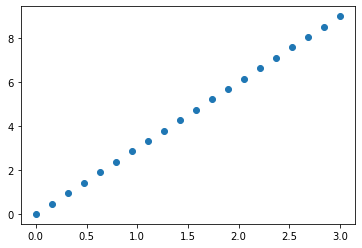

In [9]:
import matplotlib.pyplot as plt  # plt 이름은 많이 사용하는 관습임

x = np.linspace(0, 3, 20)
y = np.linspace(0, 9, 20)
# plt.plot(x, y)       # line plot
plt.plot(x, y, 'o') #위 명령어 대신 실행해보세요

In [10]:
# numpy를 python에 적용하기!
np.random.seed(777) # 고정된 random 값을 위한 seed 설정

# np.random.rand : 3개의 피쳐를 가지고 있는 1D 생성, 10만 개의 ndarray 생성
vector_1d = sc.parallelize([np.random.rand(3) for x in range(100000)])
print("★ element의 type 확인 : ", type(vector_1d.takeSample(False, 1)[0]))
print("\n★ sample의 수 : ", vector_1d.count())
print("\n★10만 개의 ndarray 중 무작위 5개 추출 v \n", vector_1d.takeSample(False, 5))


★ element의 type 확인 :  <class 'numpy.ndarray'>

★ sample의 수 :  100000

★10만 개의 ndarray 중 무작위 5개 추출 v 
 [array([0.84302378, 0.25187128, 0.14119749]), array([0.16068404, 0.5590203 , 0.33915681]), array([0.74069068, 0.12423345, 0.91980962]), array([0.20501016, 0.80891448, 0.40642239]), array([0.69586669, 0.05422543, 0.7872629 ])]


* ```arange()```를 통한 ndarray 생성

In [11]:
C = np.arange(1,5)
print("C:", C)

C: [1 2 3 4]


In [12]:
# 유용한 생성방법
c = np.linspace(0, 1, 6)   # 시작, 끝, 총 길이 즉 0과 1사이에 6개 균일한 포인트 만들기
c

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [13]:
a = np.ones((3, 3))  # reminder: (3, 3) is a tuple
a

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [14]:
b = np.zeros((2, 2))
b

array([[0., 0.],
       [0., 0.]])

In [15]:
# 단위행렬 만들기
c = np.eye(3)
c

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [16]:
# 입력 array를 대각 element로 하는 행렬 만들기 (대각 이외 element는 모두 '0')
d = np.diag(np.array([1, 2, 3, 4]))
d

array([[1, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 0, 4]])

##### B. 전치

* 벡터의 transpose [(전치행렬)](https://ko.wikipedia.org/wiki/%EC%A0%84%EC%B9%98%ED%96%89%EB%A0%AC) : 
본 강의에서 전치행렬 연산은 $\mathbf{x}^T$ 로 표기합니다. 

In [17]:
# in python
import numpy as np

sample1 = np.array([1,2,3]) # 1차원
sample2 = np.array([[1,2,3],[4,5,6]]) # 2차원
print("sample1의 shape : ", sample1.shape)
print("sample2의 shape : ", sample2.shape)

sample1의 shape :  (3,)
sample2의 shape :  (2, 3)


In [18]:
# T와 resahpe를 이용한 전치(행렬에서는 전치를 위해서 reshape 사용하지 말것)
sample1_T = sample1.T
sample1_reshape = sample1.reshape((3,1))

sample2_T = sample2.T
sample2_reshape = sample2.reshape((3,2))

print("sample1의 reshape 전치 : \n", sample1_reshape)
print("sample1의 T 전치(★1차원 array일 경우 T가 적용되지 않는다★) : \n", sample1_T)

print("\nsample2의 reshape 전치 : \n", sample2_reshape)
print("sample2의 T 전치 : \n", sample2_T)


# np.transpose(sample1) 
x = np.arange(4).reshape((2,2))
print('x: \n', x)
print('np.transpose(x): \n', np.transpose(x))

sample1의 reshape 전치 : 
 [[1]
 [2]
 [3]]
sample1의 T 전치(★1차원 array일 경우 T가 적용되지 않는다★) : 
 [1 2 3]

sample2의 reshape 전치 : 
 [[1 2]
 [3 4]
 [5 6]]
sample2의 T 전치 : 
 [[1 4]
 [2 5]
 [3 6]]
x: 
 [[0 1]
 [2 3]]
np.transpose(x): 
 [[0 2]
 [1 3]]


In [0]:
# reshape trick!!!!!
# 피쳐의 개수를 가늠하기 어려울 때, -1를 넣어주면 자동으로 피쳐의 수에 맞춰 전치가 실행된다.
sample1_reshape_trick = sample1.reshape((-1, 1))
sample2_reshape_trick = sample2.reshape((-1, 2))

print("sample1의 reshape(trick) 전치 : \n", sample1_reshape_trick)
print("\nsample2의 reshape(trick) 전치 : \n", sample2_reshape_trick)

sample1의 reshape(trick) 전치 : 
 [[1]
 [2]
 [3]]

sample2의 reshape(trick) 전치 : 
 [[1 2]
 [3 4]
 [5 6]]


* ndarray 차원 추가하기

In [19]:
z = np.array([1, 2, 3])
print("z:", z)

print("z[:, np.newaxis]: \n" , z[:, np.newaxis])
print("z[np.newaxis, :]: \n" , z[np.newaxis, :])

z: [1 2 3]
z[:, np.newaxis]: 
 [[1]
 [2]
 [3]]
z[np.newaxis, :]: 
 [[1 2 3]]


##### C. 행렬의 합 구하기 

1. $(n\times d)$ 길이를 갖는 행렬 $A$ 와 행렬 $B$의 합을 구한다

  * ```>> A+B```
2. ```dstack```을 활용하여 더하는 방법
  * ``` 
    >>> C = np.dstack([A, B]) 
    >>> print(C)
    ```  
  * ```np.sum(C, axis=2)```
  
3. **1, 2의 방법의 return 값을 확인할 것!!!**


* `+` 를 이용한 행렬의 합 구하기

In [0]:
A = np.array([1,2,3,4,5])
B = np.array([10,20,30,40,50])

print("A : ", A)
print("B : ", B)
print("A + B : ", A + B)

A :  [1 2 3 4 5]
B :  [10 20 30 40 50]
A + B :  [11 22 33 44 55]


* `sum` 를 이용한 행렬의 합 구하기
* ```np.sum(array, axis= sum하고자하는 차원입력)```

In [0]:
D=C.reshape(2,2)
print("D:", D)
E=np.sum(D,axis=0)
F=np.sum(D,axis=1)
print("axis=0 sum:", E)

print("axis=1 sum:", F)
F

D: [[1 2]
 [3 4]]
axis=0 sum: [4 6]
axis=1 sum: [3 7]


array([3, 7])

* ``np.dstack``과 ``np.sum``을 이용한 행렬의 합 구하기

In [0]:
C = np.dstack([A, B])

print("np.dstack([A,B]): ")
print(C)
print("\nnp.dstack, np.sum : ", np.sum(C, axis=2))

np.dstack([A,B]): 
[[[ 1 10]
  [ 2 20]
  [ 3 30]
  [ 4 40]
  [ 5 50]]]

np.dstack, np.sum :  [[11 22 33 44 55]]


#### (2)  Outer product of sample vectors 
우선 행렬의 기본적 [설명](https://ko.wikipedia.org/wiki/%ED%96%89%EB%A0%AC)을 참고바랍니다. 

다음은 벡터의 [외적](https://ko.wikipedia.org/wiki/%EC%99%B8%EC%A0%81)을 정의합니다. 벡터 $\mathbf{v}$의 외적은
$$
\text{Outer product} = \mathbf{v}^T \mathbf{v}
$$
* 본 강의에서는 기본 벡터 표기를 (특별히 언급하지 않는한) row vector로 사용합니다.
  * 즉 $\mathbf{v}$는 row vector (행벡터), $\mathbf{v}^T$는 column vector (열벡터)
* 위에서 외적을 설명하는 위키 링크 문서의 경우 $\mathbf{v}$의 기본 표기는 column vector로 가정합니다. 이처럼, 자료를 참고할때, 기본적으로 벡터의 모양이 어떤 형태로 되어 있는지 확인하고 공부를 하셔야 합니다.  

<br>

* **아래의 numpy.outer의 Parameter와 return을 확인해볼 것**

<p><img alt="" src="https://drive.google.com/uc?id=1dzT9jia2x3pnsXoi4Ig-q3RAeoxptvnv" style="height:324px; width:400px" /></p>

In [0]:
print("numpy의 np.outer을 사용한 sample1 outer product : \n", 
      np.outer(sample1, sample1))
print("numpy의 np.outer을 사용한 sample1 outer product : \n", 
      np.outer(sample1_reshape_trick, sample1))


print("\nnumpy의 np.outer을 사용한 sample2 outer product : \n", 
      np.outer(sample2, sample2))
print("\nnumpy의 np.outer을 사용한 sample2 outer product : \n", 
      np.outer(sample2_reshape_trick, sample2))

numpy의 np.outer을 사용한 sample1 outer product : 
 [[1 2 3]
 [2 4 6]
 [3 6 9]]
numpy의 np.outer을 사용한 sample1 outer product : 
 [[1 2 3]
 [2 4 6]
 [3 6 9]]

numpy의 np.outer을 사용한 sample2 outer product : 
 [[ 1  2  3  4  5  6]
 [ 2  4  6  8 10 12]
 [ 3  6  9 12 15 18]
 [ 4  8 12 16 20 24]
 [ 5 10 15 20 25 30]
 [ 6 12 18 24 30 36]]

numpy의 np.outer을 사용한 sample2 outer product : 
 [[ 1  2  3  4  5  6]
 [ 2  4  6  8 10 12]
 [ 3  6  9 12 15 18]
 [ 4  8 12 16 20 24]
 [ 5 10 15 20 25 30]
 [ 6 12 18 24 30 36]]


### Excercise 1 - Outer product of sample vectors (20 point)

- - -

다음 데이터에 대하여 다음 과제를 수행하세요.

- regular.csv : KBO에서 활약한 타자들의 역대 정규시즌 성적을 포함하여 몸무게, 키 ,생년월일 등의 기본정보

**위의 두 데이터는 모두 `,`로 구분되어 있습니다.**

 - **데이터의 자세한 설명은 다음의 링크를 참조해주세요.([여기를 눌러서 데이터 설명 참고](https://dacon.io/cpt6/62885))**
 - 또한 regular.csv를 직접 열어서 데이터가 어떻게 저장되어 있는지 확인해주세요.

**task**

* 1 : 주어지는 code는 ``regular.csv``에 특정 기준을 적용하여 생성되는 RDD입니다. ``생성되는 RDD가 어떤 RDD인지 자세하게 2 ~ 3줄 이내로 설명``하세요. (5 point)

<br>

* 2 : 

    ``RDD_to_outer`` 함수는 ``ndarray``를 ``parameter``를 받아 ``outer product를 return`` 합니다.(10 point)

<br>

* 3 : ``task1에서 주어진 RDD``에 ``map``을 이용하여 ``RDD_to_outer``를 적용합니다. (10 point)

**task**

* 1 : 주어지는 code는 ``regular.csv``에 특정 기준을 적용하여 생성되는 RDD입니다. ``생성되는 RDD가 어떤 RDD인지 자세하게 2 ~ 3줄 이내로 설명``하세요. (5 point)

In [0]:
import urllib.request
import re

f = urllib.request.urlretrieve ("https://docs.google.com/uc?export=download&id=1b_L-rJYJC9Oqga0fQ2zh2M763CTM8jzR", "regular.csv")
regular = sc.textFile("./regular.csv").map(lambda x : x.split(","))

def stringToFloat(element): # G R H RBI BB
    float_list = []
    for index in [5,7,8,13,16]:
        float_list.append(float(element[index]) if element[index] != '' else float(0))
    return (int(element[0]), np.array(float_list, dtype = 'float64'))

RDD_step1 = regular.filter(lambda x : x[3] == "두산").map(stringToFloat).cache()
RDD_step2 = RDD_step1.reduceByKey(lambda x, y : x + y).sortByKey().map(lambda x : x[1]).cache()

#### task 1 답안 작성:
여기에 입력하시오!!!

**task**

* 2 : 

    ``RDD_to_outer`` 함수는 ``ndarray``를 ``parameter``를 받아 ``outer product를 return`` 합니다.(10 point)

<br>

* 3 : ``task1에서 주어진 RDD``에 ``map``을 이용하여 ``RDD_to_outer``를 적용합니다. (10 point)

```
# task 1-3 output
[array([[63504., 18900., 26460., 13608., 13104.],
        [18900.,  5625.,  7875.,  4050.,  3900.],
        [26460.,  7875., 11025.,  5670.,  5460.],
        [13608.,  4050.,  5670.,  2916.,  2808.],
        [13104.,  3900.,  5460.,  2808.,  2704.]]),
 array([[772641., 375333., 510699., 256668., 244362.],
        [375333., 182329., 248087., 124684., 118706.],
        [510699., 248087., 337561., 169652., 161518.],
        [256668., 124684., 169652.,  85264.,  81176.],
        [244362., 118706., 161518.,  81176.,  77284.]])]
```

In [0]:
# 1 - 2 답안 작성
def RDD_to_outer(ndarray):
    # 여기에 작성

    
# 1 - 3 답안 작성

# output
task3_result.take(2)

### 1. 공분산 구하기 첫번째 방법
1. Sample vector $\mathbf{x}_i$, $i=1,\ldots, n$와 평균 벡터 $\bar{\mathbf{x}}$ 에 대해서 다음 연산을 수행합니다. 
2. $\tilde{\mathbf{x}}_i = \mathbf{x}_i-\bar{\mathbf{x}}$
3. 각 벡터 $\tilde{\mathbf{x}}_i$의 outer product (외적)을 구합니다
\begin{align*}
\tilde{\mathbf{O}}_i = \tilde{\mathbf{x}}_i^T \tilde{\mathbf{x}}_i
\end{align*}
4. Sample covariance matrix는 다음과 같이 정의됩니다!
\begin{align*}
\text{Cov}_1(\mathbf{x}) = \frac{1}{n} \sum_{i=1}^n \tilde{\mathbf{O}}_i
\end{align*}

In [0]:
# 위 절차에 맞추어서 공분산 1 번째 방법으로 구하기 
# in python
import numpy as np

sample1 = np.array([1,2,3])
sample2 = np.array([4,5,6])
sample3 = np.array([7,8,9])

print("각 sample의 값 : ", sample1, sample2, sample3)

# 평균 벡터 구하기
sample_sum = np.dstack([sample1, sample2])
sample_sum = np.sum(np.dstack([sample_sum, sample3]), axis = 2)
sample_mean = sample_sum / 3

# 평균이 빼진 각 sample의 outer product 구하기
# sample에서 평균 벡터 빼기
sample1_del_mean = sample1 - sample_mean
sample2_del_mean = sample2 - sample_mean
sample3_del_mean = sample3 - sample_mean

# outerproduct 구하기
sample1_outer = np.outer(sample1_del_mean,sample1_del_mean)
sample2_outer = np.outer(sample2_del_mean,sample2_del_mean)
sample3_outer = np.outer(sample3_del_mean,sample3_del_mean)

# Sample covariance matrix 구하기
sample_cov = np.dstack([sample1_outer, sample2_outer])
sample_cov = np.sum(np.dstack([sample_cov, sample3_outer]), axis = 2) / 3

print("\nSample covariance matrix : ")
print(sample_cov)

각 sample의 값 :  [1 2 3] [4 5 6] [7 8 9]

Sample covariance matrix : 
[[6. 6. 6.]
 [6. 6. 6.]
 [6. 6. 6.]]


In [0]:
# in spark
vector_list = sc.parallelize([np.array([1,2,3]),np.array([4,5,6]),np.array([7,8,9])])
print("각 sample의 값 : ", vector_list.collect())

# 평균 벡터 구하기
sample_sum = vector_list\
    .reduce(lambda ndarr1, ndarr2 : np.sum(np.dstack([ndarr1, ndarr2]), axis=2))
sample_mean = sample_sum / vector_list.count()

# 평균이 빼진 각 sample의 outer product 구하기
# sample에서 평균 벡터 빼기 및 outerproduct
vector_outer = vector_list.map(lambda x : x - sample_mean)\
                          .map(lambda x : np.outer(x, x)).cache()

# Sample covariance matrix
sample_cov = vector_outer.reduce(lambda x, y : np.sum(np.dstack([x, y]), axis=2))
print("\nSample covariance matrix : ")
print(sample_cov / vector_list.count())


각 sample의 값 :  [array([1, 2, 3]), array([4, 5, 6]), array([7, 8, 9])]

Sample covariance matrix : 
[[6. 6. 6.]
 [6. 6. 6.]
 [6. 6. 6.]]



### Excercise 2 - 
#### 공분산 구하기 첫 번째 방법을 적용해 보자! (25 point)

- - -

``Excercise1 에서 주어진 RDD_step2를 이용하여 진행``합니다.

- - -

**task**
1. $\bar{\mathbf{x}} = \frac{1}{n}\sum_{i=1}^n \mathbf{x}_i$ (평균 벡터 구하기) (5 point)
    - `평균 벡터 구하는 방법은 HW7를 참조합시다.!`
2. $\tilde{\mathbf{x}}_i = \mathbf{x}_i-\bar{\mathbf{x}}$ (sample에서 평균 벡터 빼기) (5 point)
3. 각 벡터 $\tilde{\mathbf{x}}_i$의 outer product (외적)을 구하기 (5 point)
\begin{align*}
\tilde{\mathbf{O}}_i = \tilde{\mathbf{x}}_i^T \tilde{\mathbf{x}}_i
\end{align*}
4. Sample covariance matrix (10 point)
\begin{align*}
\text{Cov}_1(\mathbf{x}) = \frac{1}{n} \sum_{i=1}^n \tilde{\mathbf{O}}_i
\end{align*}

**task**
1. $\bar{\mathbf{x}} = \frac{1}{n}\sum_{i=1}^n \mathbf{x}_i$ (평균 벡터 구하기) (5 point)

```
Exercise 1에서 생성한 RDD_step2 를 이용합니다.
 PythonRDD[86] at RDD at PythonRDD.scala:53 
 
# task 2-1 output
sample sum :  [[22250.  9689. 17891.  9259.  6733.]]
sample count :  52
sample mean :  [[427.88461538 186.32692308 344.05769231 178.05769231 129.48076923]]
```

In [0]:
print("Exercise 1에서 생성한 RDD_step2 를 이용합니다.\n",RDD_step2,"\n")

# 2 - 1 답안 작성

# output
print("sample sum : ", sample_sum)
print("sample count : ", RDD_step2.count())
print("sample mean : ", sample_mean)

**task**
2. $\tilde{\mathbf{x}}_i = \mathbf{x}_i-\bar{\mathbf{x}}$ (sample에서 평균 벡터 빼기) (5 point)

<br>

3. 각 벡터 $\tilde{\mathbf{x}}_i$의 outer product (외적)을 구하기 (5 point)
\begin{align*}
\tilde{\mathbf{O}}_i = \tilde{\mathbf{x}}_i^T \tilde{\mathbf{x}}_i
\end{align*}

```
# task 2-3 output 예시(출력 결과는 다를 수 있습니다)
[[30935.39792899 19580.69304734 42046.57026627 21819.83949704
  13627.67529586]
 [19580.69304734 12393.68380178 26613.55732249 13810.96116864
   8625.69563609]
 [42046.57026627 26613.55732249 57148.58025148 29656.94563609
  18522.37389053]
 [21819.83949704 13810.96116864 29656.94563609 15390.31102071
   9612.08542899]
 [13627.67529586  8625.69563609 18522.37389053  9612.08542899
   6003.26960059]]
 ```

In [0]:
# task 2-2와 2-3 답안 작성

# output
print("# task 3 output 예시(출력 결과는 다를 수 있습니다)")
print(sample_outer.first())

**task**
4. Sample covariance matrix
\begin{align*}
\text{Cov}_1(\mathbf{x}) = \frac{1}{n} \sum_{i=1}^n \tilde{\mathbf{O}}_i
\end{align*}

```
# task 2-4 output
Sample covariance matrix 방법1 결과(동일한 결과가 출력되어야 합니다): 
[[191231.67899408  92257.69156805 179270.89127219  94635.62204142
   70490.86316568]
 [ 92257.69156805  47359.72004438  90009.30806213  47427.92344675
   35666.34282544]
 [179270.89127219  90009.30806213 177880.51590237  95548.9966716
   70259.24149408]
 [ 94635.62204142  47427.92344675  95548.9966716   54126.05436391
   39050.81841716]
 [ 70490.86316568  35666.34282544  70259.24149408  39050.81841716
   29639.63424556]]
   ```

In [0]:
# 2-4 답안 작성

# output
print("Sample covariance matrix 방법1 결과(동일한 결과가 출력되어야 합니다): ")
print(cov1)

### Excercise 3 - 
#### 공분산 구하기 두 번째 방법을 적용해 보자! (25 point)

- - -

``Excercise1 에서 주어진 RDD_step2를 이용하여 진행``합니다.

- - -
#### 공분산 구하기 두번째 방법

1. Sample vector $\mathbf{x}_i$, $i=1,\ldots, n$와 평균 벡터 $\bar{\mathbf{x}}$ 에 대해서 다음 연산을 수행합니다. 
2. $\tilde{\mathbf{x}}_i = \mathbf{x}_i-\bar{\mathbf{x}}$
3. 다음과 같이 행렬을 만듭니다 (10 point)
\begin{align*}
\mathbf{X} = 
\left[
\begin{array}{c}
\tilde{\mathbf{x}}_1 \\
\tilde{\mathbf{x}}_2 \\
\vdots \\
\tilde{\mathbf{x}}_{n-1} \\
\tilde{\mathbf{x}}_{n} 
\end{array}
\right] = 
\left[
\begin{array}{cccc}
x_{11} - \bar{x}_{11} & x_{12} - \bar{x}_{12} & \cdots & x_{1d} - \bar{x}_{1d} \\
x_{21} - \bar{x}_{21} & x_{22} - \bar{x}_{22} & \cdots & x_{2d} - \bar{x}_{2d} \\
\vdots & &\ddots & \vdots \\
x_{n1} - \bar{x}_{n1} & x_{n2} - \bar{x}_{n2} & \cdots & x_{nd} - \bar{x}_{nd} \\
\end{array}
\right]
\end{align*}

<br>

4. Sample covariance matrix는 다음과 같이 정의됩니다(15 point)
    - 행렬곱을 진행할 때, ``.T`` 또는 ``reshape``와 ``np.matmul``을 사용할 것!
\begin{align*}
\text{Cov}_2(\mathbf{x}) &= \frac{1}{n}\mathbf{X}^T \mathbf{X} \\
&= \left[
\begin{array}{cccc}
x_{11} - \bar{x}_{11} & x_{21} - \bar{x}_{21} & \cdots & x_{n1} - \bar{x}_{n1} \\
x_{12} - \bar{x}_{12} & x_{22} - \bar{x}_{22} & \cdots & x_{n2} - \bar{x}_{n2} \\
\vdots & &\ddots & \vdots \\
x_{1d} - \bar{x}_{1d} & x_{2d} - \bar{x}_{2d} & \cdots & x_{nd} - \bar{x}_{nd} \\
\end{array}
\right]\left[
\begin{array}{cccc}
x_{11} - \bar{x}_{11} & x_{12} - \bar{x}_{12} & \cdots & x_{1d} - \bar{x}_{1d} \\
x_{21} - \bar{x}_{21} & x_{22} - \bar{x}_{22} & \cdots & x_{2d} - \bar{x}_{2d} \\
\vdots & &\ddots & \vdots \\
x_{n1} - \bar{x}_{n1} & x_{n2} - \bar{x}_{n2} & \cdots & x_{nd} - \bar{x}_{nd} \\
\end{array}
\right]
\end{align*}

**task**
1. Sample vector $\mathbf{x}_i$, $i=1,\ldots, n$와 평균 벡터 $\bar{\mathbf{x}}$ 에 대해서 다음 연산을 수행합니다. 
2. $\tilde{\mathbf{x}}_i = \mathbf{x}_i-\bar{\mathbf{x}}$
3. 다음과 같이 행렬을 만듭니다( **np.vstack 이용할 것** ) (10 point)
\begin{align*}
\mathbf{X} = 
\left[
\begin{array}{c}
\tilde{\mathbf{x}}_1 \\
\tilde{\mathbf{x}}_2 \\
\vdots \\
\tilde{\mathbf{x}}_{n-1} \\
\tilde{\mathbf{x}}_{n} 
\end{array}
\right] = 
\left[
\begin{array}{cccc}
x_{11} - \bar{x}_{11} & x_{12} - \bar{x}_{12} & \cdots & x_{1d} - \bar{x}_{1d} \\
x_{21} - \bar{x}_{21} & x_{22} - \bar{x}_{22} & \cdots & x_{2d} - \bar{x}_{2d} \\
\vdots & &\ddots & \vdots \\
x_{n1} - \bar{x}_{n1} & x_{n2} - \bar{x}_{n2} & \cdots & x_{nd} - \bar{x}_{nd} \\
\end{array}
\right]
\end{align*}

```
Exercise 1에서 생성한 RDD_step2 를 이용합니다.
 -> PythonRDD[86] at RDD at PythonRDD.scala:53 

Exercise 2에서 생성한 sample mean 을 이용합니다.
 -> [[427.88461538 186.32692308 344.05769231 178.05769231 129.48076923]]

#task 3-3 output
 -> [[-175.88461538 -111.32692308 -239.05769231 -124.05769231  -77.48076923]
 [ 451.11538462  240.67307692  236.94230769  113.94230769  148.51923077]
 [-284.88461538 -133.32692308 -272.05769231 -131.05769231  -98.48076923]
 [1072.11538462  595.67307692 1244.94230769  829.94230769  655.51923077]
 [-391.88461538 -174.32692308 -334.05769231 -174.05769231 -127.48076923]
 [-389.88461538 -174.32692308 -338.05769231 -176.05769231 -124.48076923], 
                                .
                                .
                                .
```

In [0]:
print("Exercise 1에서 생성한 RDD_step2 를 이용합니다.\n ->",RDD_step2,"\n")
print("Exercise 2에서 생성한 sample mean 을 이용합니다.\n ->", sample_mean)

# 3 - 3 답안 작성

# output
print("\ntask 3-3 output\n ->", task3_3)

**task**
4. Sample covariance matrix는 다음과 같이 정의됩니다 (15 point)
    - 행렬곱을 진행할 때, ``.T`` 또는 ``reshape``와 ``np.matmul``을 사용할 것!
\begin{align*}
\text{Cov}_2(\mathbf{x}) &= \frac{1}{n}\mathbf{X}^T \mathbf{X} \\
&= \left[
\begin{array}{cccc}
x_{11} - \bar{x}_{11} & x_{21} - \bar{x}_{21} & \cdots & x_{n1} - \bar{x}_{n1} \\
x_{12} - \bar{x}_{12} & x_{22} - \bar{x}_{22} & \cdots & x_{n2} - \bar{x}_{n2} \\
\vdots & &\ddots & \vdots \\
x_{1d} - \bar{x}_{1d} & x_{2d} - \bar{x}_{2d} & \cdots & x_{nd} - \bar{x}_{nd} \\
\end{array}
\right]\left[
\begin{array}{cccc}
x_{11} - \bar{x}_{11} & x_{12} - \bar{x}_{12} & \cdots & x_{1d} - \bar{x}_{1d} \\
x_{21} - \bar{x}_{21} & x_{22} - \bar{x}_{22} & \cdots & x_{2d} - \bar{x}_{2d} \\
\vdots & &\ddots & \vdots \\
x_{n1} - \bar{x}_{n1} & x_{n2} - \bar{x}_{n2} & \cdots & x_{nd} - \bar{x}_{nd} \\
\end{array}
\right]
\end{align*}

```
# task 3-4 output
Sample covariance matrix 방법2 결과(동일한 결과가 출력되어야 합니다)
 -> [[191231.67899408  92257.69156805 179270.89127219  94635.62204142
   70490.86316568]
 [ 92257.69156805  47359.72004438  90009.30806213  47427.92344675
   35666.34282544]
 [179270.89127219  90009.30806213 177880.51590237  95548.9966716
   70259.24149408]
 [ 94635.62204142  47427.92344675  95548.9966716   54126.05436391
   39050.81841716]
 [ 70490.86316568  35666.34282544  70259.24149408  39050.81841716
   29639.63424556]]

cov1과 cov2의 비교(오차)
 ->  0.0
 ```

In [0]:
# 3-4 답안 작성

# output
print("Sample covariance matrix 방법2 결과(동일한 결과가 출력되어야 합니다)\n ->", cov2)
print("\ncov1과 cov2의 비교(오차)\n -> ", 
     sum((np.round(np.ravel(cov1), 2) - np.round(np.ravel(cov2), 2)) **2))

### Excercise 4 - 
#### 공분산 구하기 세 번째 방법을 적용해 보자! (25 point)

- - -

``Excercise1 에서 주어진 RDD_step2를 이용하여 진행``합니다.

- - -

#### 공분산 구하기 세번째 방법

1. Sample vector $\mathbf{x}_i$, $i=1,\ldots, n$와 평균 벡터 $\bar{\mathbf{x}}$ 에 대해서 다음 연산을 수행합니다. 
2. 각 벡터 $\mathbf{x}_i$의 outer product (외적)을 구합니다. (10 point)
\begin{align*}
\mathbf{O}_i = \mathbf{x}_i^T \mathbf{x}_i
\end{align*}
**(★주의★) 위에서와 같이 평균을 뺀 벡터가 아닙니다!**

<br>

3. 평균 벡터의 외적을 구합니다
\begin{align*}
\bar{\mathbf{O}} = \bar{\mathbf{x}}^T \bar{\mathbf{x}}
\end{align*}

<br>

4. Sample covariance matrix는 다음과 같이 구합니다
\begin{align*}
\text{Cov}_3(\mathbf{x}) &= \left(\frac{1}{n}\sum_{i=1}^n \mathbf{O}_i\right) - \bar{\mathbf{O}}
\end{align*}

**task**

1. Sample vector $\mathbf{x}_i$, $i=1,\ldots, n$와 평균 벡터 $\bar{\mathbf{x}}$ 에 대해서 다음 연산을 수행합니다. 
2. 각 벡터 $\mathbf{x}_i$의 outer product (외적)을 구합니다. (10 point)
\begin{align*}
\mathbf{O}_i = \mathbf{x}_i^T \mathbf{x}_i
\end{align*}
**(★주의★) 위에서와 같이 평균을 뺀 벡터가 아닙니다!**

<br>

3. 평균 벡터의 외적을 구합니다. (5 point)
\begin{align*}
\bar{\mathbf{O}} = \bar{\mathbf{x}}^T \bar{\mathbf{x}}
\end{align*}

```
Exercise 1에서 생성한 RDD_step2 를 이용합니다.
 -> PythonRDD[86] at RDD at PythonRDD.scala:53 

Exercise 2에서 생성한 sample mean 을 이용합니다.
 -> [[427.88461538 186.32692308 344.05769231 178.05769231 129.48076923]]

# task 4-3 output
 -> [[183085.24408284  79726.42381657 147216.9933432   76188.14718935
   55402.82914201]
 [ 79726.42381657  34717.72226331  64107.21116864  33176.94193787
   24125.7533284 ]
 [147216.9933432   64107.21116864 118375.69563609  61262.11871302
   44548.85465976]
 [ 76188.14718935  33176.94193787  61262.11871302  31704.54178994
   23055.04696746]
 [ 55402.82914201  24125.7533284   44548.85465976  23055.04696746
   16765.26960059]]
   ```

In [0]:
print("Exercise 1에서 생성한 RDD_step2 를 이용합니다.\n ->",RDD_step2,"\n")
print("Exercise 2에서 생성한 sample mean 을 이용합니다.\n ->", sample_mean)

# 4 - 2 답안 작성

# output
print("\n평균 벡터의 외적\n ->", sample_mean_outer)

**task**

4. Sample covariance matrix는 다음과 같이 구합니다. (10 point)
\begin{align*}
\text{Cov}_3(\mathbf{x}) &= \left(\frac{1}{n}\sum_{i=1}^n \mathbf{O}_i\right) - \bar{\mathbf{O}}
\end{align*}

```
# task 4-4 output
Sample covariance matrix 방법3 결과(동일한 결과가 출력되어야 합니다)
 -> [[191231.67899408  92257.69156805 179270.89127219  94635.62204142
   70490.86316568]
 [ 92257.69156805  47359.72004438  90009.30806213  47427.92344675
   35666.34282544]
 [179270.89127219  90009.30806213 177880.51590237  95548.9966716
   70259.24149408]
 [ 94635.62204142  47427.92344675  95548.9966716   54126.05436391
   39050.81841716]
 [ 70490.86316568  35666.34282544  70259.24149408  39050.81841716
   29639.63424556]]

cov1과 cov3의 비교(오차)
 ->  0.0
```

In [0]:
# 4 - 4 답안 작성

# output
print("Sample covariance matrix 방법3 결과(동일한 결과가 출력되어야 합니다)\n ->", cov3)

print("\ncov1과 cov3의 비교(오차)\n -> ", 
     sum((np.round(np.ravel(cov1), 2) - np.round(np.ravel(cov2), 2)) **2))


 ![hi](http://www.filetalk.net/data/editor/1812/3b62f2a770e8c0fb20a6ee8d7368d27c_1545872435_993.gif)**수**
![hi2](https://images2.imgbox.com/91/ec/mGQ8RQCe_o.gif)**고**